<a href="https://colab.research.google.com/github/tsibikina/Labs_HPC/blob/main/MatMul_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed Oct 16 19:43:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


In [ ]:
import numpy as np
import cupy as cp
import time
from numba import jit
from tabulate import tabulate

In [ ]:
class cuda_kernels():
    @staticmethod
    def matmul_cuda():
        kernel = cp.RawKernel(r'''
        #include <cupy/complex.cuh>
        extern "C"{
            __global__ void matmul(const double *A, const double *B, double *C, int m, int n, int p)
            {
                int row = blockIdx.y * blockDim.y + threadIdx.y;
                int col = blockIdx.x * blockDim.x + threadIdx.x;
                if (row < m && col < p) {
                    double sum = 0.0;
                    for (int k = 0; k < n; k++) {
                        sum += A[row * n + k] * B[k * p + col];
                    }
                    C[row * p + col] = sum;
                }
            }
        }''', 'matmul')
        return kernel

@jit
def matmul(A, B, m, n, p):
    C = np.zeros((m,p))
    for i in range(m):
        for j in range(p):
            for k in range(n):
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
    return C

In [ ]:
# Функция для генерации случайных матриц
def generate_matrices(m, n, p):
    A = np.random.rand(m, n)
    B = np.random.rand(n, p)
    return A, B

# Функция для выполнения умножения матриц на CUDA
def cuda_matrix_multiplication(A, B, m, n, p):
    A_gpu = cp.asarray(A)
    B_gpu = cp.asarray(B)
    C_gpu = cp.zeros((m, p), dtype=np.float64)

    kernel = cuda_kernels.matmul_cuda()
    threads_per_block = (16, 16)
    blocks_per_grid_x = int(np.ceil(p / threads_per_block[0]))
    blocks_per_grid_y = int(np.ceil(m / threads_per_block[1]))
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    start_cuda = time.time()
    kernel(blocks_per_grid, threads_per_block, (A_gpu, B_gpu, C_gpu, m, n, p))
    cp.cuda.Stream.null.synchronize()
    end_cuda = time.time()
    time_cuda = end_cuda - start_cuda

    C_cuda = cp.asnumpy(C_gpu)
    return C_cuda, time_cuda

# Функция для выполнения умножения матриц на NumPy
def numpy_matrix_multiplication(A, B, m, n, p):
    start_numpy = time.time()
    C_numpy = np.matmul(A, B)
    end_numpy = time.time()
    time_numpy = end_numpy - start_numpy
    return C_numpy, time_numpy

# Функция для проверки корректности результатов
def check_correctness(C_cuda, C_numpy):
    return np.allclose(C_cuda, C_numpy, rtol=1e-5, atol=1e-5)

In [ ]:
# Основная функция для запуска эксперимента
def run_experiment(m, n, p):
    A, B = generate_matrices(m, n, p)
    C_cuda, time_cuda = cuda_matrix_multiplication(A, B, m, n, p)
    C_numpy, time_numpy = numpy_matrix_multiplication(A, B, m, n, p)
    correct = check_correctness(C_cuda, C_numpy)
    speedup = time_numpy / time_cuda
    return time_cuda, time_numpy, correct, speedup

# Список размеров матриц для экспериментов
sizes = [(100, 100, 100), (500, 500, 500), (1000, 1000, 1000), (2000, 2000, 2000)]
results = []

# Запуск экспериментов
for m, n, p in sizes:
    time_cuda, time_numpy, correct, speedup = run_experiment(m, n, p)
    results.append((m, n, p, time_cuda, time_numpy, speedup, correct))

# Заголовки столбцов
headers = ["Matrix Size (m, n, p)", "CUDA Time (s)", "NumPy Time (s)", "Speedup", "Correct"]

# Форматирование данных
formatted_results = []
for result in results:
    formatted_results.append([
        f"{result[0]}x{result[1]}x{result[2]}",
        f"{result[3]:.6f}",
        f"{result[4]:.6f}",
        f"{result[5]:.2f}",
        'Yes' if result[6] else 'No'
    ])

# Вывод таблицы
print(tabulate(formatted_results, headers=headers, tablefmt="grid")


+-------------------------+-----------------+------------------+-----------+-----------+
| Matrix Size (m, n, p)   |   CUDA Time (s) |   NumPy Time (s) |   Speedup | Correct   |
+=========================+=================+==================+===========+===========+
| 100x100x100             |        0.000198 |         0.166418 |    839.96 | Yes       |
+-------------------------+-----------------+------------------+-----------+-----------+
| 500x500x500             |        0.00304  |         0.16868  |     55.49 | Yes       |
+-------------------------+-----------------+------------------+-----------+-----------+
| 1000x1000x1000          |        0.023245 |         1.6534   |     71.13 | Yes       |
+-------------------------+-----------------+------------------+-----------+-----------+
| 2000x2000x2000          |        0.180023 |        20.1322   |    111.83 | Yes       |
+-------------------------+-----------------+------------------+-----------+-----------+


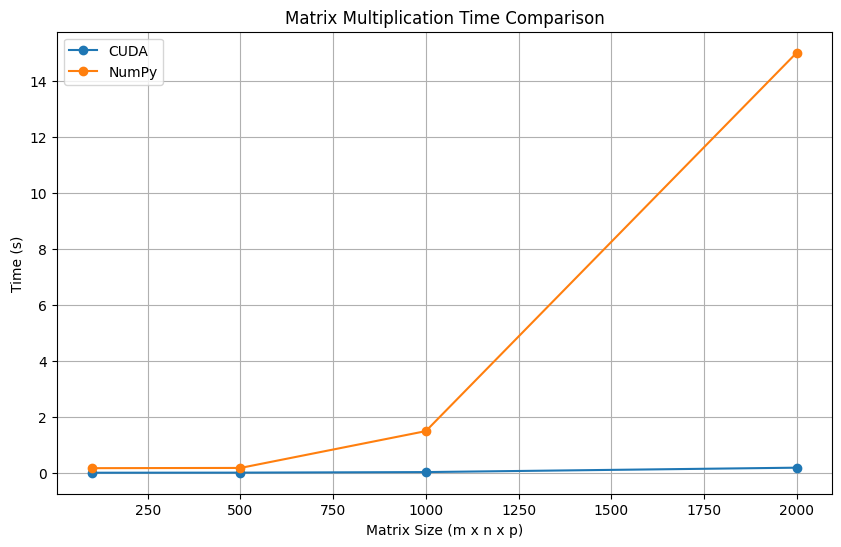

In [ ]:
import matplotlib.pyplot as plt

# Извлечение данных для построения графика
matrix_sizes = [result[0] for result in results]
cuda_times = [result[3] for result in results]
numpy_times = [result[4] for result in results]

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, cuda_times, label='CUDA', marker='o')
plt.plot(matrix_sizes, numpy_times, label='NumPy', marker='o')
plt.xlabel('Matrix Size (m x n x p)')
plt.ylabel('Time (s)')
plt.title('Matrix Multiplication Time Comparison')
plt.legend()
plt.grid(True)
plt.show()